In [10]:
import moviepy.editor as mp
import os

def extract_video_segment(video_path, start_time, end_time=None, fps=None, save_path="output.mov"):
    # Check if the input file is .mp4
    filename, file_extension = os.path.splitext(video_path)
    if file_extension == ".mp4":
        # Convert .mp4 to .mov
        clip = mp.VideoFileClip(video_path)
        video_path = filename + ".mov"
        clip.write_videofile(video_path, codec="libx264", audio_codec="aac")

    video = mp.VideoFileClip(video_path)
    if end_time is None:
        end_time = video.duration
    segment = video.subclip(start_time, end_time)
    if fps is None:
        fps = video.fps
    segment.write_videofile(save_path, codec="libx264", audio_codec="aac", fps=fps)

video_dir = "./analysis/labeling/start_2023-11-16T19-50-24.725+00-00/2024-01-26T16-39+00-00_label/"
video_path = video_dir + "original_binary_output.mp4"
save_path = video_path.replace("original_binary_output.mp4", "binary_output_120s.mov")
extract_video_segment(video_path, start_time=120, save_path=save_path)

t:   1%|▏         | 14/960 [2:28:38<167:24:10, 637.05s/it, now=None]

Moviepy - Building video ./analysis/labeling/start_2023-11-16T19-50-24.725+00-00/2024-01-26T16-39+00-00_label/original_binary_output.mov.
Moviepy - Writing video ./analysis/labeling/start_2023-11-16T19-50-24.725+00-00/2024-01-26T16-39+00-00_label/original_binary_output.mov



t:   1%|▏         | 14/960 [2:28:44<167:30:30, 637.45s/it, now=None]

Moviepy - Done !
Moviepy - video ready ./analysis/labeling/start_2023-11-16T19-50-24.725+00-00/2024-01-26T16-39+00-00_label/original_binary_output.mov


t:   1%|▏         | 14/960 [2:28:44<167:30:43, 637.47s/it, now=None]

Moviepy - Building video ./analysis/labeling/start_2023-11-16T19-50-24.725+00-00/2024-01-26T16-39+00-00_label/binary_output_120s.mov.
Moviepy - Writing video ./analysis/labeling/start_2023-11-16T19-50-24.725+00-00/2024-01-26T16-39+00-00_label/binary_output_120s.mov



t:   1%|▏         | 14/960 [2:28:49<167:36:40, 637.84s/it, now=None]

Moviepy - Done !
Moviepy - video ready ./analysis/labeling/start_2023-11-16T19-50-24.725+00-00/2024-01-26T16-39+00-00_label/binary_output_120s.mov


In [ ]:
import glob
import yaml

import yaml
from algorithm.FishDetector import FishDetector
from algorithm.InputOutputHandler import InputOutputHandler

video_dirs = glob.glob("./analysis/labeling/*")
yaml_file = './analysis/demo/demo_settings.yaml'

for video_dir in video_dirs:
    video_dir = video_dir.replace("\\", "/")
    input_file = video_dir + "/original.mp4"
    with open(yaml_file) as f:
        settings_dict = yaml.load(f, Loader=yaml.SafeLoader)
        if input_file is not None:
            settings_dict["input_file"] = input_file
            settings_dict['output_directory'] = video_dir
            print("replacing input file with: ", input_file)

    input_output_handler = InputOutputHandler(settings_dict)
    detector = FishDetector(settings_dict)
    object_history = {}

    while input_output_handler.get_new_frame():
        if float(input_output_handler.frame_no) / 2 % 1 != 0:
            continue
        detections, processed_frame_dict, runtimes = detector.detect_objects(
            input_output_handler.current_raw_frame
        )
        object_history = detector.associate_detections(detections, object_history)
        input_output_handler.handle_output(
            processed_frame_dict, object_history, runtimes, detector=detector
        )

    if input_output_handler.output_csv_name is not None:
        detections = input_output_handler.get_detections_pd(object_history)
        detections = detector.classify_detections(detections)
        detections.to_csv(input_output_handler.output_csv_name, index=False)
        
    # cut off the first 120 seconds as burn-in and convert to mov for roboflow
    record_processing_frame = settings_dict["record_processing_frame"]
    out_dir = next(d for d in os.listdir(video_dir) if os.path.isdir(os.path.join(video_dir, d)))
    base_name = os.path.basename(video_dir)

    out_video_path = os.path.join(video_dir, out_dir, f"original_{record_processing_frame}_output.mp4")
    save_binary_path = os.path.join(video_dir, out_dir, f"{base_name}_{record_processing_frame}_output_120s.mov")
    extract_video_segment(out_video_path, start_time=120, save_path=save_binary_path)
    print(f"Saved {save_binary_path}")

1:
<algorithm.DetectedObject.DetectedObject object at 0x0000027337D4E200>
special variables
function variables
ID:
1
areas:
[321.0, 353.0]
bounding_boxes:
[(24, 19), (26, 20)]
deepsort_detection:
<algorithm.DetectedObject.MyDeepSortDetection object at 0x0000027337D4E260>
frames_observed:
[410, 411]
midpoints:
[(309, 207), (302, 206)]
velocities:
[array([nan, nan]), array([nan, nan])]

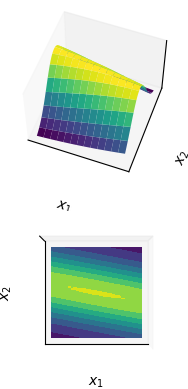

[[23.    0.35]
 [-9.    0.93]]


: 

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

# Our 2-dimensional distribution will be over variables X and Y
N = 40
X = np.linspace(-2, 2, N)
Y = np.linspace(-2, 2, N)
X, Y = np.meshgrid(X, Y)

# Mean vector and covariance matrix
mu = np.array([0., 0.])
Sigma = np.array([[23., 0.35], [-9, 0.93]])

# Pack X and Y into a single 3-dimensional array
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

def multivariate_gaussian(pos, mu, Sigma):
    """Return the multivariate Gaussian distribution on array pos."""

    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    N = np.sqrt((2*np.pi)**n * Sigma_det)
    # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
    # way across all the input variables.
    fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)

    return np.exp(-fac / 2) / N

# The distribution on the variables X, Y packed into pos.
Z = multivariate_gaussian(pos, mu, Sigma)

# plot using subplots
fig = plt.figure()
ax1 = fig.add_subplot(2,1,1,projection='3d')

ax1.plot_surface(X, Y, Z, rstride=3, cstride=3, linewidth=1, antialiased=True,
                cmap=cm.viridis)
ax1.view_init(55,-70)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_zticks([])
ax1.set_xlabel(r'$x_1$')
ax1.set_ylabel(r'$x_2$')

ax2 = fig.add_subplot(2,1,2,projection='3d')
ax2.contourf(X, Y, Z, zdir='z', offset=0, cmap=cm.viridis)
ax2.view_init(90, 270)

ax2.grid(False)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_zticks([])
ax2.set_xlabel(r'$x_1$')
ax2.set_ylabel(r'$x_2$')

plt.show()
print(Sigma)